<a href="https://colab.research.google.com/github/Udbhavbisarya23/Table_Detection_Structure_Recogntion/blob/main/IT416_Course_Project_TrackA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 set up

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.8 torchvision -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 763.5 MB 15 kB/s 
     |████████████████████████████████| 23.3 MB 1.8 MB/s 
     |████████████████████████████████| 22.1 MB 53.0 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 17.3 MB 17 kB/s 
     |████████████████████████████████| 17.4 MB 102 kB/s 
     |████████████████████████████████| 17.3 MB 186 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depende

In [ ]:
# install detectron2:
# !pip install fvcore==0.1.1.dev200512
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 714 kB/s 
     |████████████████████████████████| 130 kB 6.1 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 145 kB 45.7 MB/s 
     |████████████████████████████████| 74 kB 3.5 MB/s 
     |████████████████████████████████| 743 kB 42.2 MB/s 
     |████████████████████████████████| 749 kB 36.9 MB/s 
     |████████████████████████████████| 112 kB 54.0 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=ef76ab439350ff71f73bbececda0cfccac956079607cf3670223eb72450f96ab
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=7c765ff9fd14c0e609d073b2240c06edbeaa786ccd30c3ea920c314a5c02669

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Table Detection using ICDAR-2019 Track A

Here, the ground truth format of Track A dataset is converted to COCO format. Using Faster-RCNN the table detection is done and evaluated



In [ ]:
# # !/usr/bin/python

# # pip install lxml

import sys
import os
import json
import xml.etree.ElementTree as ET
import glob
import detectron2
import random
from detectron2 import structures
from detectron2.structures import BoxMode

START_BOUNDING_BOX_ID = 1
PRE_DEFINE_CATEGORIES = None


def ground_truth_to_COCO(xml_files):
    import cv2
    final = {}
    final["categories"] = [{
        "id": 0,
        "name": "table",
        "supercategory": "none"
    }]
    dataset = []
    img_dir_path = '/content/drive/MyDrive/IT-416-Course-Project/TrackA/ground_truth/images/'
    count = 0
    for xmlfile in xml_files:
        tree = ET.parse(xmlfile)
        root = tree.getroot()
        print(root.attrib['filename'])
        im = cv2.imread(os.path.join(img_dir_path + root.attrib['filename']))
        objs = []
        for table in root:
            for element in table:
                # Table coordinates
                obj = {}
                if element.tag == 'Coords':
                  coords = element.attrib['points'].split(" ")
                  temp = []
                  for ele in coords:
                      x,y = ele.split(",")
                      x,y = int(x), int(y)
                      temp.append(x)
                      temp.append(y)
                  obj = {
                      "bbox": [temp[0], temp[1], temp[4], temp[5]],
                      "bbox_mode": BoxMode.XYXY_ABS,
                      "segmentation": [temp],
                      "category_id": 0,
                      "iscrowd": 0
                  }
                else:
                  for coord in element:
                    coords = coord.attrib['points'].split(" ")
                    temp = []
                    tempxarr = []
                    tempyarr = []
                    for ele in coords:
                        x,y = ele.split(",")
                        x,y = int(x), int(y)
                        temp.append(x)
                        temp.append(y)
                        tempxarr.append(x)
                        tempyarr.append(y)
                    obj = {
                      "bbox": [int(np.min(tempxarr)), int(np.min(tempyarr)), int(np.max(tempxarr)), int(np.max(tempyarr))],
                      "bbox_mode": BoxMode.XYXY_ABS,
                      "segmentation": [temp],
                      "category_id": 1,
                      "iscrowd": 0
                    }
                objs.append(obj)
        
        dataset.append({
            "file_name": os.path.join(img_dir_path,root.attrib['filename']),
            "image_id": count,
            "height": im.shape[0],
            "width": im.shape[1],
            "annotations": objs
        })
        
        count += 1
    
    return dataset




xml_files = glob.glob(os.path.join('/content/drive/MyDrive/IT-416-Course-Project/TrackA/ground_truth/annotations', "*.xml"))
# If you want to do train/test split, you can pass a subset of xml files to convert function.
random.shuffle(xml_files)
print(len(xml_files))
val_dataset = ground_truth_to_COCO(xml_files[1100:])

json_file = '/content/drive/MyDrive/IT-416-Course-Project/TrackA/coco/val.json'

os.makedirs(os.path.dirname(json_file), exist_ok=True)
json_fp = open(json_file, "w")

print(val_dataset)
json_str = json.dumps(val_dataset)
json_fp.write(json_str)
json_fp.close()


train_dataset = ground_truth_to_COCO(xml_files[:1100])

json_file = '/content/drive/MyDrive/IT-416-Course-Project/TrackA/coco/train.json'

os.makedirs(os.path.dirname(json_file), exist_ok=True)
json_fp = open(json_file, "w")
json_str = json.dumps(train_dataset)
json_fp.write(json_str)
json_fp.close()

1200
cTDaR_t10212.jpg
cTDaR_t00606.jpg
cTDaR_t00902.jpg
cTDaR_t00403.jpg
cTDaR_t00803.jpg
cTDaR_t00470.JPG
cTDaR_t10532.jpg
cTDaR_t10537.jpg
cTDaR_t10435.jpg
cTDaR_t10139.jpg
cTDaR_t00362.jpg
cTDaR_t10480.jpg
cTDaR_t10102.jpg
cTDaR_t00571.jpg
cTDaR_t10231.jpg
cTDaR_t10107.jpg
cTDaR_t10250.jpg
cTDaR_t00267.jpg
cTDaR_t00872.jpg
cTDaR_t10363.jpg
cTDaR_t00671.jpg
cTDaR_t00601.jpg
cTDaR_t00917.jpg
cTDaR_t00281.jpg
cTDaR_t10046.jpg
cTDaR_t00677.jpg
cTDaR_t10322.jpg
cTDaR_t00121.jpg
cTDaR_t00263.jpg
cTDaR_t00206.JPG
cTDaR_t00530.jpg
cTDaR_t10484.jpg
cTDaR_t00618.jpg
cTDaR_t00434.jpg
cTDaR_t00422.jpg
cTDaR_t00709.jpg
cTDaR_t00023.jpg
cTDaR_t10310.jpg
cTDaR_t00314.jpg
cTDaR_t00763.jpg
cTDaR_t10064.jpg
cTDaR_t10585.jpg
cTDaR_t10494.jpg
cTDaR_t00899.jpg
cTDaR_t10015.jpg
cTDaR_t00521.jpg
cTDaR_t00610.jpg
cTDaR_t10023.jpg
cTDaR_t10433.jpg
cTDaR_t10558.jpg
cTDaR_t10115.jpg
cTDaR_t10077.jpg
cTDaR_t10198.jpg
cTDaR_t00600.jpg
cTDaR_t10306.jpg
cTDaR_t10174.jpg
cTDaR_t00454.JPG
cTDaR_t00408.jpg
cTDaR_t10

In [ ]:
import json, os
from detectron2.data import MetadataCatalog, DatasetCatalog


def load_data(t):
    if t == "train":
        with open("/content/drive/MyDrive/IT-416-Course-Project/TrackA/coco/train.json", 'r') as file:
            train = json.load(file)
        return train
    elif t == "val":
      with open("/content/drive/MyDrive/IT-416-Course-Project/TrackA/coco/val.json", 'r') as file:
          val = json.load(file)
    return val

from detectron2.engine import DefaultTrainer


for d in ["train", "val"]:
    DatasetCatalog.register(d, lambda d=d: load_data(d))
    MetadataCatalog.get(d).set(thing_classes=["Table"])

metadata = MetadataCatalog.get("train")


In [ ]:
import random
dataset_dicts = load_data("train")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    print(d)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

{'file_name': '/content/drive/MyDrive/IT-416-Course-Project/TrackA/ground_truth/images/cTDaR_t00355.jpg', 'image_id': 929, 'height': 4468, 'width': 5853, 'annotations': [{'bbox': [112, 505, 5830, 4442], 'bbox_mode': 0, 'segmentation': [[112, 505, 5830, 505, 5830, 4442, 112, 4442]], 'category_id': 0, 'iscrowd': 0}]}


In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "/content/drive/MyDrive/IT-416-Course-Project/TrackA/output/model/"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/11 08:04:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:14, 11.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pre

[11/11 08:04:29 d2.engine.train_loop]: Starting training from iteration 0
[11/11 08:05:06 d2.utils.events]:  eta: 1:17:53  iter: 19  total_loss: 0.9352  loss_cls: 0.7843  loss_box_reg: 0.0837  loss_rpn_cls: 0.03138  loss_rpn_loc: 0.01714  time: 1.7527  data_time: 0.5456  lr: 4.9953e-06  max_mem: 2675M
[11/11 08:05:37 d2.utils.events]:  eta: 1:13:00  iter: 39  total_loss: 0.8644  loss_cls: 0.6434  loss_box_reg: 0.1058  loss_rpn_cls: 0.0674  loss_rpn_loc: 0.02722  time: 1.6280  data_time: 0.1083  lr: 9.9902e-06  max_mem: 2675M
[11/11 08:06:18 d2.utils.events]:  eta: 1:14:57  iter: 59  total_loss: 0.565  loss_cls: 0.3832  loss_box_reg: 0.09442  loss_rpn_cls: 0.02664  loss_rpn_loc: 0.02337  time: 1.7620  data_time: 0.5842  lr: 1.4985e-05  max_mem: 2729M
[11/11 08:06:52 d2.utils.events]:  eta: 1:14:44  iter: 79  total_loss: 0.399  loss_cls: 0.242  loss_box_reg: 0.09745  loss_rpn_cls: 0.01876  loss_rpn_loc: 0.02741  time: 1.7449  data_time: 0.2939  lr: 1.998e-05  max_mem: 2729M
[11/11 08:07:

In [ ]:
torch.save(trainer.model.state_dict(),'/content/drive/MyDrive/IT-416-Course-Project/TrackA/output/Faster_rcnn.pth')

# from detectron2.checkpoint import DetectionCheckpointer, Checkpointer
# checkpointer = DetectionCheckpointer(trainer.model, save_dir='/content/drive/MyDrive/CV_Data/output')
# checkpointer.save("mymodel_0")

#Prediction for IoU = 0.5

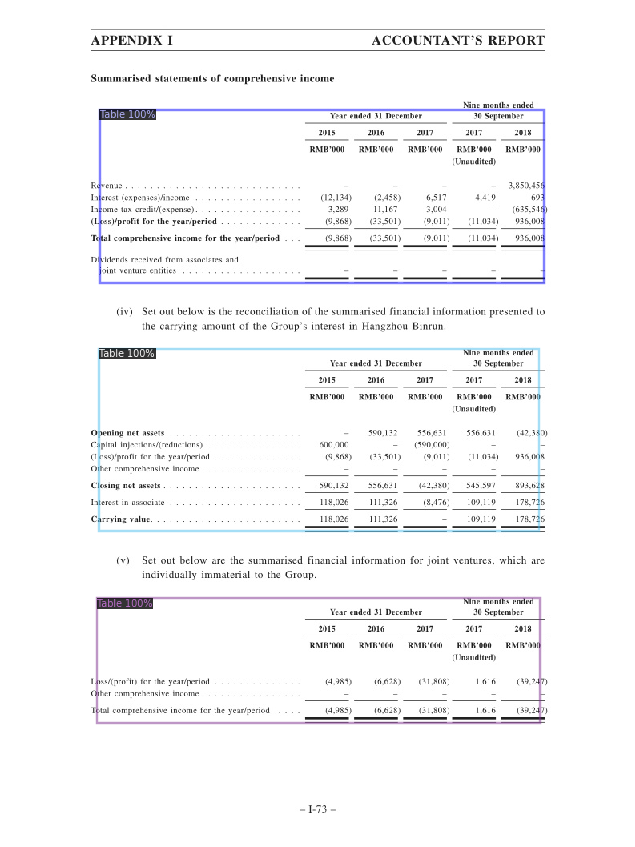

In [ ]:
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("val")
predictor = DefaultPredictor(cfg)


dataset_dicts = load_data('val')
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "val")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [11/03 19:11:38 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/03 19:11:38 d2.evaluation.coco_evaluation]: Trying to convert 'val' to COCO format ...
[11/03 19:11:38 d2.data.datasets.coco]: Converting annotations of dataset 'val' to COCO format ...)
[11/03 19:11:38 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/03 19:11:38 d2.data.datasets.coco]: Conversion finished, #images: 100, #annotations: 141
[11/03 19:11:38 d2.data.datasets.coco]: Caching COCO format annotations at '/output/val_coco_format.json' ...
[11/03 19:11:38 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Table    | 141          |
|            |              |
[11/03 19:11:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=133

OrderedDict([('bbox',
              {'AP': 82.68088206563131,
               'AP50': 93.12058926417346,
               'AP75': 90.92415698979322,
               'APl': 82.68088206563131,
               'APm': nan,
               'APs': nan})])

#Prediction for IoU = 0.6


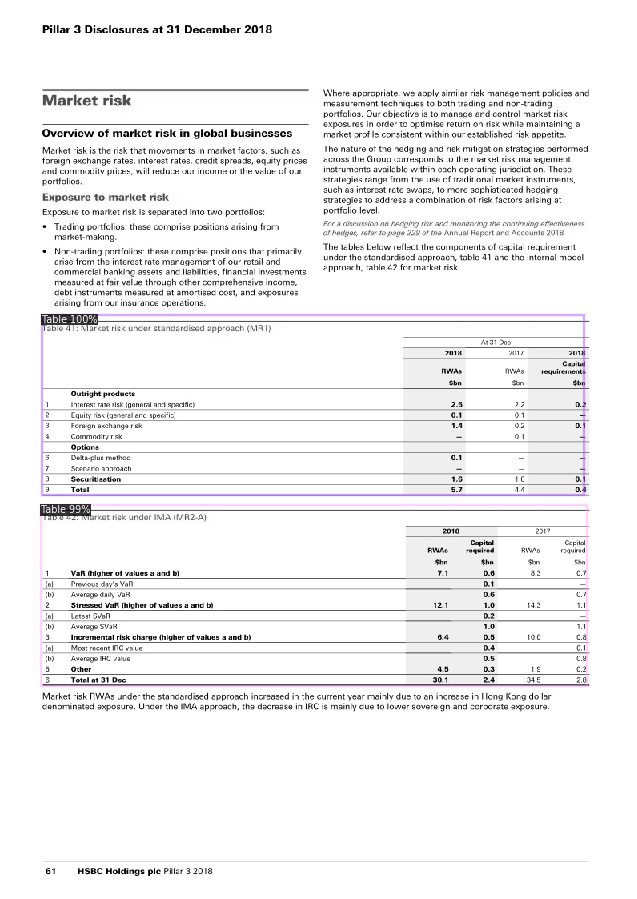

In [ ]:
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 
cfg.DATASETS.TEST = ("val")
predictor = DefaultPredictor(cfg)


dataset_dicts = load_data('val')
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "val")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [11/11 09:25:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/11 09:25:31 d2.evaluation.coco_evaluation]: Trying to convert 'val' to COCO format ...
[11/11 09:25:31 d2.data.datasets.coco]: Converting annotations of dataset 'val' to COCO format ...)
[11/11 09:25:31 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/11 09:25:31 d2.data.datasets.coco]: Conversion finished, #images: 100, #annotations: 141
[11/11 09:25:31 d2.data.datasets.coco]: Caching COCO format annotations at '/output/val_coco_format.json' ...
[11/11 09:25:31 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Table    | 141          |
|            |              |
[11/11 09:25:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=133

OrderedDict([('bbox',
              {'AP': 79.03071906679664,
               'AP50': 90.87656068401671,
               'AP75': 88.66945595365404,
               'APl': 79.03071906679664,
               'APm': nan,
               'APs': nan})])

In [ ]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "val")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)